In [64]:
import os, sys
from pathlib import Path

p = Path(os.getcwd()).resolve()
while p != p.parent and not (p / "src").exists():
    p = p.parent
sys.path.insert(0, str(p))
print("Project root:", p)


Project root: /Users/cafer/Desktop/PHYS 414/final_project


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [66]:
df = pd.read_csv("../data/white_dwarf_data.csv")

In [67]:
# Physical constants
G = 6.67430e-8          # cm^3 g^-1 s^-2
M_sun = 1.98847e33      # g
R_sun = 6.957e10        # cm
R_earth = 6.371e8       # cm

# Assumption: 'mass' (solar units), 'logg' (cgs)
M = df["mass"].values * M_sun
logg = df["logg"].values
g = 10**logg

# Radius (cm and solar units)
R = np.sqrt(G * M / g)
R_solar = R / R_sun
R_earth_units = R / R_earth
M_solar = M / M_sun


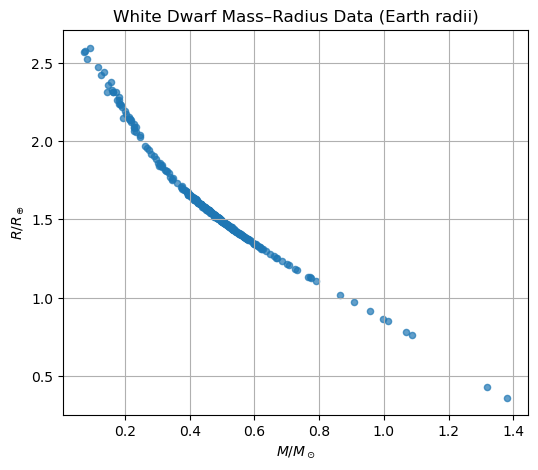

In [68]:
plt.figure(figsize=(6,5))
plt.scatter(M_solar, R_earth_units, s=20, alpha=0.7)

plt.xlabel(r"$M / M_\odot$")
plt.ylabel(r"$R / R_\oplus$")
plt.title("White Dwarf Mass–Radius Data (Earth radii)")
plt.grid(True)

plt.savefig("../figures/white_dwarf_MR_earth.png", dpi=200, bbox_inches="tight")
plt.show()


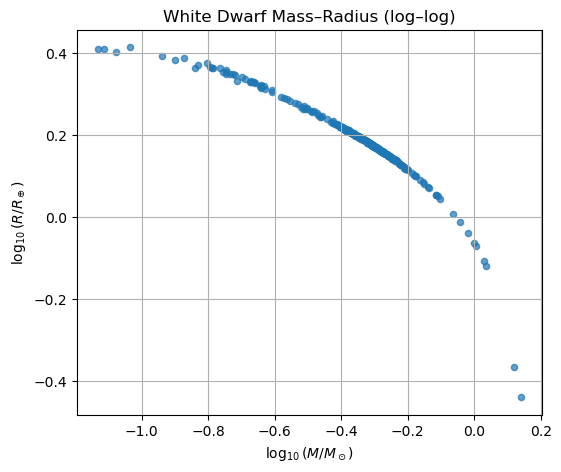

In [69]:
plt.figure(figsize=(6,5))
plt.scatter(np.log10(M_solar), np.log10(R_earth_units), s=20, alpha=0.7)

plt.xlabel(r"$\log_{10}(M/M_\odot)$")
plt.ylabel(r"$\log_{10}(R/R_\oplus)$")
plt.title("White Dwarf Mass–Radius (log–log)")
plt.grid(True)

plt.savefig("../figures/white_dwarf_MR_loglog_earth.png", dpi=200, bbox_inches="tight")
plt.show()


In [70]:
mask = M_solar < 0.4   # low-mass cutoff (can adjust later)

M_low = M_solar[mask]
R_low = R_solar[mask]

print(f"Using {len(M_low)} low-mass points")


Using 76 low-mass points


In [71]:
coeffs = np.polyfit(np.log10(M_low), np.log10(R_low), 1)
alpha = coeffs[0]
intercept = coeffs[1]

print("Power-law slope alpha =", alpha)


Power-law slope alpha = -0.3107513356243013


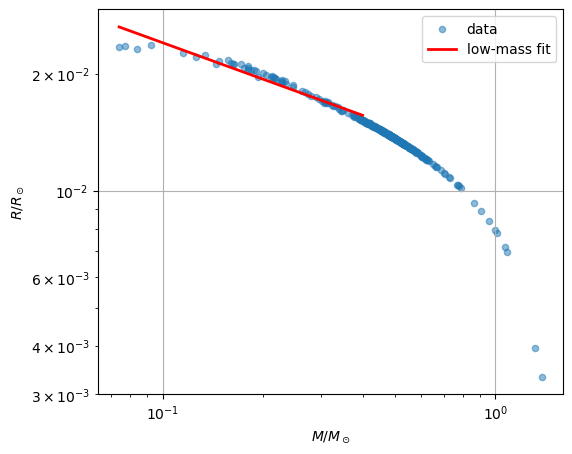

In [72]:
M_fit = np.linspace(min(M_low), max(M_low), 200)
R_fit = 10**intercept * M_fit**alpha

plt.figure(figsize=(6,5))
plt.scatter(M_solar, R_solar, s=20, alpha=0.5, label="data")
plt.plot(M_fit, R_fit, color="red", lw=2, label="low-mass fit")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$M/M_\odot$")
plt.ylabel(r"$R/R_\odot$")
plt.legend()
plt.grid(True)

plt.savefig("../figures/white_dwarf_lowmass_fit.png",
            dpi=200, bbox_inches="tight")
plt.show()


In [73]:
n_star = (1 - 3*alpha) / (1 - alpha)
print("n* =", n_star)


n* = 1.4741575723457765


In [74]:
C = 10**intercept
print("Fit constant C in R = C * M^alpha:", C)


Fit constant C in R = C * M^alpha: 0.011765717111872409


In [75]:
from src.lane_emden import solve_lane_emden

sol_ns = solve_lane_emden(n_star, xi_max=50.0)
print("n* =", n_star)
print("xi1(n*) =", sol_ns.xi1)
print("mass coeff -theta'(xi1)/xi1 =", sol_ns.mass_coeff)


n* = 1.4741575723457765
xi1(n*) = 3.623403610656761
mass coeff -theta'(xi1)/xi1 = 0.05744086186676626


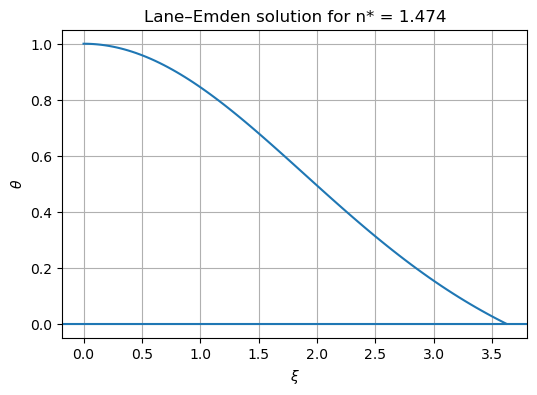

In [76]:
plt.figure(figsize=(6,4))
plt.plot(sol_ns.xi, sol_ns.theta)
plt.axhline(0)
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\theta$")
plt.title(f"Lane–Emden solution for n* = {n_star:.3f}")
plt.grid(True)
plt.savefig("../figures/lane_emden_nstar_theta.png", dpi=200, bbox_inches="tight")
plt.show()


In [77]:
# pick one low-mass point (e.g. closest to 0.3 Msun)
target = 0.30
i = np.argmin(np.abs(M_solar - target))

M_obs = M_solar[i]   # in Msun
R_obs = R_solar[i]   # in Rsun

print("Chosen star:")
print("M/Msun =", M_obs)
print("R/Rsun =", R_obs)


Chosen star:
M/Msun = 0.301
R/Rsun = 0.017014673819776147


In [78]:

# constants (cgs)
M_sun = 1.98847e33   # g
R_sun = 6.957e10     # cm

# observed star (solar units -> cgs)
M = M_obs * M_sun
R = R_obs * R_sun

xi1 = sol_ns.xi1
mass_coeff = sol_ns.mass_coeff   # = -theta'(xi1)/xi1

# from Lane–Emden: -xi1^2 theta'(xi1) = (mass_coeff) * xi1^3
A = mass_coeff * xi1**3

# R = a xi1  => a = R/xi1
a = R / xi1

# M = 4π a^3 ρc A  => ρc = M / (4π a^3 A)
rho_c = M / (4*np.pi * a**3 * A)

print("rho_c [g/cm^3] =", rho_c)
print("log10(rho_c) =", np.log10(rho_c))


rho_c [g/cm^3] = 499939.9396948845
log10(rho_c) = 5.698917833484373


In [79]:
# Compute rho_c for all stars in the low-mass mask you used for the fit

M_cgs = M_solar[mask] * M_sun
R_cgs = R_solar[mask] * R_sun

xi1 = sol_ns.xi1
mass_coeff = sol_ns.mass_coeff
A = mass_coeff * xi1**3  # -xi1^2 theta'(xi1)

a_all = R_cgs / xi1
rho_c_all = M_cgs / (4*np.pi * a_all**3 * A)

print("rho_c range [g/cm^3]:", rho_c_all.min(), rho_c_all.max())
print("log10 rho_c range:", np.log10(rho_c_all).min(), np.log10(rho_c_all).max())


rho_c range [g/cm^3]: 46621.39039764565 928356.1813099785
log10 rho_c range: 4.668585221415807 5.96771463343792


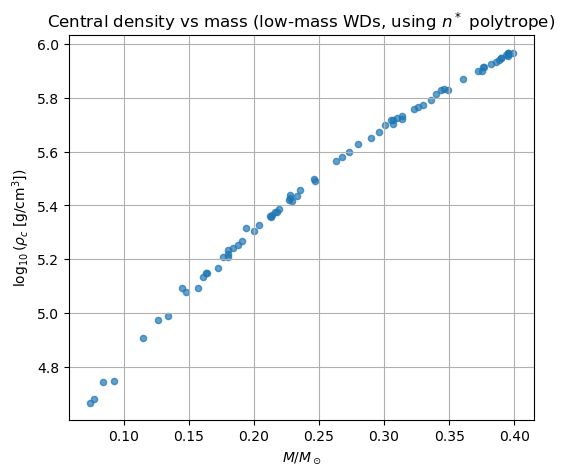

In [80]:
plt.figure(figsize=(6,5))
plt.scatter(M_solar[mask], np.log10(rho_c_all), s=20, alpha=0.7)
plt.xlabel(r"$M/M_\odot$")
plt.ylabel(r"$\log_{10}(\rho_c\;[\mathrm{g/cm^3}])$")
plt.title(r"Central density vs mass (low-mass WDs, using $n^*$ polytrope)")
plt.grid(True)

plt.savefig("../figures/rhoc_vs_mass_lowmass.png", dpi=200, bbox_inches="tight")
plt.show()


In [81]:
gamma_star = 1 + 1/n_star
print("n* =", n_star)
print("gamma* =", gamma_star)


n* = 1.4741575723457765
gamma* = 1.678353534764085


In [82]:

G = 6.67430e-8      # cgs
R_sun = 6.957e10    # cm

xi1 = sol_ns.xi1
R_cgs = R_obs * R_sun
a = R_cgs / xi1

K_star = (4*np.pi*G/(n_star + 1)) * a**2 * (rho_c**(1 - 1/n_star))

print("a [cm] =", a)
print("K* [cgs] =", K_star, " (units: dyne cm^2 g^{-gamma})")
print("log10 K* =", np.log10(K_star))


a [cm] = 326684792.7623699
K* [cgs] = 2463104548403.834  (units: dyne cm^2 g^{-gamma})
log10 K* = 12.391482846200143


In [83]:
R_cgs_all = R_solar[mask] * R_sun
a_all = R_cgs_all / xi1

K_all = (4*np.pi*G/(n_star + 1)) * a_all**2 * (rho_c_all**(1 - 1/n_star))

print("K* range:", K_all.min(), K_all.max())
print("log10 K* range:", np.log10(K_all).min(), np.log10(K_all).max())
print("median log10 K*:", np.median(np.log10(K_all)))


K* range: 2191518936427.2942 2583133778596.4346
log10 K* range: 12.340745227648135 12.412146898547201
median log10 K*: 12.395324730357508


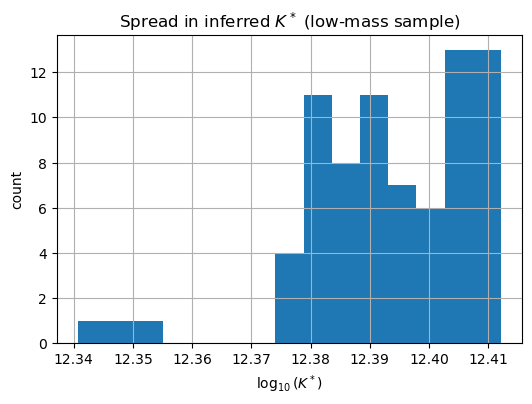

In [84]:
plt.figure(figsize=(6,4))
plt.hist(np.log10(K_all), bins=15)
plt.xlabel(r"$\log_{10}(K^*)$")
plt.ylabel("count")
plt.title(r"Spread in inferred $K^*$ (low-mass sample)")
plt.grid(True)
plt.savefig("../figures/Kstar_hist.png", dpi=200, bbox_inches="tight")
plt.show()